In [2]:
import pandas as pd
import numpy as np
import json
import os
import string
import re
import random
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split



from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.neural_network import MLPRegressor as MLPR
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Perceptron 




%matplotlib inline

# Global Variables

In [3]:
seed = 2293687334
random.seed(seed)
np.random.seed(seed)

#  Import and Clean Data

In [4]:
#  Reduce JSON product to key features 

def load_clean_vectorize():

    def extract_key_prod_values(passed_json_prod):
        review_vol = len(passed_json_prod['Reviews'])
        avg_score = 0.0

        for review in passed_json_prod['Reviews']:
            if pd.isnull(review['Overall']) or review['Overall'] is None or review['Overall'] == 'None':
                continue
            avg_score += float(review['Overall'])
        if review_vol <= 0:
            avg_score = -1
        else:
            avg_score /= review_vol

        price = passed_json_prod['ProductInfo']['Price']
        name = passed_json_prod['ProductInfo']['Name']
        features = passed_json_prod['ProductInfo']['Features']

        return [name, features, price, avg_score, review_vol]



    cleaned_prods = []


    #  TODO:  need to change these absolute paths
    
#     paths = ['/home/tuna/Projects/CS673/amazon_api/dumps/cameras/',
#             '/home/tuna/Projects/CS673/amazon_api/dumps/laptops/',
#             '/home/tuna/Projects/CS673/amazon_api/dumps/mobilephone/',
#             '/home/tuna/Projects/CS673/amazon_api/dumps/tablets/',
#             '/home/tuna/Projects/CS673/amazon_api/dumps/TVs/',
#             '/home/tuna/Projects/CS673/amazon_api/dumps/video_surveillance/']
#     path_cameras = '/home/tuna/Projects/CS673/amazon_api/dumps/cameras/'
    paths = ['amazon_api/dumps/cameras/',
            'amazon_api/dumps/laptops/',
            'amazon_api/dumps/mobilephone/',
            'amazon_api/dumps/tablets/',
            'amazon_api/dumps/TVs/',
            'amazon_api/dumps/video_surveillance/']
    path_cameras = 'amazon_api/dumps/cameras/'


    #  go through every file in directory and convert to json/clean
    for path in paths:
        for filename in os.listdir(path):
    #         print(filename)

            try:
                raw_prod_json = json.load(file(path + filename))
            except ValueError as e:
                print("**************ERROR********************")
            cleaned_prod_json = extract_key_prod_values(raw_prod_json)
            cleaned_prods.append(cleaned_prod_json)



    cleaned_prods_df = pd.DataFrame(cleaned_prods)
    cleaned_prods_df.columns = ['name', 'features', 'price', 'avg_score', 'review_vol']
#     cleaned_prods_df.head()



    #  TODO:  now I need to throw out missing data
    cleaned_prods_df = cleaned_prods_df[pd.notnull(cleaned_prods_df.features)]
    cleaned_prods_df = cleaned_prods_df[pd.notnull(cleaned_prods_df.price)]
    cleaned_prods_df = cleaned_prods_df[pd.notnull(cleaned_prods_df.avg_score)]
    cleaned_prods_df = cleaned_prods_df[pd.notnull(cleaned_prods_df.review_vol)]
    cleaned_prods_df = cleaned_prods_df[cleaned_prods_df.review_vol > 0]
    cleaned_prods_df = cleaned_prods_df[cleaned_prods_df.price != "Unavailable"]
# cleaned_prods_df.head()


    vector_prop_df = cleaned_prods_df.copy(deep=True)
    name_list = vector_prop_df['name']
    features_list = vector_prop_df['features']
    vector_prop_df['description'] = [name_list.iloc[i] + " " + features_list.iloc[i] 
                                     for i in range(len(vector_prop_df))]


#     vector_prop_df.head()

    
    

    def clean_string_for_tokens(passed_string):
        cleaned_string = string.replace(passed_string, "\n", " ")
        cleaned_string = cleaned_string.lower()
        cleaned_string = re.sub('((\d+|\S+)[\.])(?!([\d]+))','\g<2>',cleaned_string)
        cleaned_string = re.sub('[^a-z.\-A-Z0-9+]', " ", cleaned_string)
        cleaned_string = re.sub('\+', " ", cleaned_string)

        return cleaned_string
    
    
    
    vector_prop_df['description'] = \
        [clean_string_for_tokens(desc) for desc in vector_prop_df['description']]
        
        
        
        
    #  extract tf-idf scores while removing stopwords. I'm using this to first build a 
    #  set of the most important words... then I'll go through each description and
    #  count how many times each of the words appear then this will be that product's
    #  vector representation. So this first step is simply 
    from sklearn.feature_extraction.text import TfidfVectorizer
    corpus = list(vector_prop_df['description'])
    vectorizer = TfidfVectorizer(min_df=0.005, stop_words='english', strip_accents='ascii')
    #                              ngram_range=(3,100), max_df=1.0)
    X = vectorizer.fit_transform(corpus)
    idf = vectorizer.idf_
    word_scores = dict(zip(vectorizer.get_feature_names(), idf))
    top_ranked_words = sorted(word_scores.items(), key = lambda x: x[1], reverse=True)[:1000]
    top_ranked_words = np.asarray(top_ranked_words)[:,0]
#     top_ranked_words[:20]



    #  turn a description into a vector of the top ranked words
    def vectorize_description(desc_str, top_ranked_words):
        product_vector = np.zeros(len(top_ranked_words))

        for word in desc_str.split(" "):
            if not word:
                continue
            word_index = np.where(top_ranked_words==word)[0]
            if len(word_index) <= 0:
                continue
            else:
                product_vector[word_index[0]] += 1

        return product_vector

    vector_prop_df['feature_vector'] = \
        [vectorize_description(desc, top_ranked_words) for desc in vector_prop_df['description']]
        
        
        
    return vector_prop_df, top_ranked_words

In [5]:
def get_words_from_vec(vec, top_ranked_words):
    bool_vec = vec > 0
    print(set(top_ranked_words[bool_vec]))
    return set(top_ranked_words[bool_vec])

In [6]:
##  output to file for use with the vaccum discovery script
# vector_prop_df.to_excel('vectorized_products.xlsx')


In [7]:
#prods_original, top_ranked_words = load_clean_vectorize()

# Generator

In [220]:
def dimensionality_reduction(prods_original, kpca_dim):

    prod_vectors = prods_original['feature_vector'].as_matrix()
#     prod_vectors = list(prod_vectors.astype('str'))
#     tmp = []
#     for prod_str in prod_vectors:
#         tmp_array = np.asarray(re.split("\s+", prod_str.replace('\n', ' ')[1:-1].strip())).astype(float)
#         tmp.append(tmp_array)
#     prod_vectors = tmp
    prod_vectors = np.atleast_2d(list(prod_vectors))


    #  change to binary values
    prod_vectors_cleaned = (prod_vectors > 0).astype(int)


    #    reduce the featurs down to 2 dimensions, find the gaps with e clustering algorithm,
    #    then use kernel PCA to fransform these points back into features mappings
    #    these final mappings will be the proposed projects
    theshold_inv_value = 0.03
    kpca_model = KernelPCA(n_components=kpca_dim, kernel='poly', fit_inverse_transform=True, n_jobs=-1,
                               degree=4)
    prod_vectors = prod_vectors_cleaned
    kpca_model.fit(prod_vectors)
    embedded_prods = kpca_model.transform(prod_vectors)
    
    return embedded_prods, kpca_model


def dimensionality_projection(embedding, kpca_model):
    return kpca_model.inverse_transform(embedding)



In [9]:
#embedded_prods, kpca_model = dimensionality_reduction(prods_original)

In [10]:
#plt.scatter(embedded_prods[:,0], embedded_prods[:,1])

In [11]:
# new_product_proposals = 

#  Evaluator

In [12]:
def train_evaluator(prods_original):
    
    #  extract vector for x, some aggregate of avg_score, price, and review vol for y
    prod_vectors_x = prods_original['feature_vector'].as_matrix()
#     prod_vectors_x = list(prod_vectors_x.astype('str'))
#     tmp = []
#     for prod_str in prod_vectors_x:
#         tmp_array = np.asarray(re.split("\s+", prod_str.replace('\n', ' ')[1:-1].strip())).astype(float)
#         tmp.append(tmp_array)
#     prod_vectors_x = tmp
    prod_vectors_x = np.atleast_2d(list(prod_vectors_x))

    #  change to binary values
    prod_vectors_x = (prod_vectors_x > 0).astype(int)
    prod_vectors_x

        #  create prod_vectors_y (price, avg score, reviw vol)
    price_list = prods_original['price']
    score_list = prods_original['avg_score']
    vol_list = prods_original['review_vol']




    #  TODO: need to define what important to us, this values total revenue above all us
    def calculate_value(price, score, vol):
    #     price = price.replace(',','')
    #     price = float(price.split('.')[0][1:])
        score = float(score)
        vol = float(vol)
        return 1.0 + (score - 1.0)*(1.0 - 1.0/(vol/10.0 + 1.0))
    
    
    
    prod_vectors_y = [calculate_value(price_list.iloc[i], score_list.iloc[i], vol_list.iloc[i]) \
                  for i in range(len(price_list))]

    
    
    X_train, X_test, y_train, y_test = train_test_split(prod_vectors_x, prod_vectors_y, test_size=0.2)
#     new_prod_vectors_x = new_prods_original.as_matrix()
    
    
    #  final model
    model = RFR(n_jobs=-1, oob_score=True, n_estimators=100, max_depth=None, max_features=2)
    model.fit(prod_vectors_x, prod_vectors_y)
#     model.score(prod_vectors_x, prod_vectors_y)

    return model

    
    
    
    
    

def rank_products(model, new_prod_vectors):
    new_prod_scores = model.predict(new_prod_vectors)
    
    new_prod_combined_scores = np.hstack((new_prod_vectors_x, np.atleast_2d(new_prod_scores).T))
    top_ranked_prods = np.asarray(sorted(new_prod_combined_scores, key=lambda x: -x[-1]))
    return top_ranked_prods
    
    
    
# new_prods_original

In [13]:
#model = train_evaluator(prods_original)

#   Grid Sampler

In [31]:
from Product_Explorer import Explorer

In [35]:
class Explorer(object):
    THRESHOLD = 10 # Calculated as follows: 1/1+e^-(THRESHOLD*distance-5)
                  # Higher number = less penalty for being close
    MIN_DISTANCE = 1 # Just to avoid division by 0, we need a minimum distance
    DISTANCE_EXPONENT = 2 # Higher makes it less likely to sample distant points
    DISTANCE_SCALER = 0.2 # Adjust this to make the scale of the graph make sense

    def __init__(self):
        self.kernels = 0

    #embedded_prods
    def generate_space(self, embedded_prods, percent_increase=0.2):
        self.known_points = embedded_prods
        xs = embedded_prods[:,0]
        ys = embedded_prods[:,1]
        minx = np.min(xs)
        miny = np.min(ys)
        maxx = np.max(xs)
        maxy = np.max(ys)
        self.min_x = minx - (maxx-minx)*percent_increase
        self.max_x = maxx + (maxx-minx)*percent_increase
        self.min_y = miny - (maxy-miny)*percent_increase
        self.max_y = maxy + (maxy-miny)*percent_increase

    def gridify_space(self, x_dim=20, y_dim=20):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.x_spacing = (self.max_x - self.min_x)/x_dim
        self.y_spacing = (self.max_y - self.min_y)/y_dim
        self.x_start = self.min_x + self.x_spacing/2
        self.y_start = self.min_y + self.y_spacing/2
        test_points = np.mgrid[self.x_start:self.x_start+self.x_dim*self.x_spacing:self.x_spacing, self.y_start:self.y_start+self.y_dim*self.y_spacing:self.y_spacing].reshape(2,-1).T
        return test_points

    def calc_min_dist(self, test_points):
        dists = np.empty((0,1))
        for i in xrange(test_points.shape[0]):
            mindist = np.min(np.sqrt(np.sum(np.power(self.known_points-test_points[i,:2], 2), axis=1)))
            dists = np.vstack((dists, np.atleast_2d(mindist)))
        return dists

    def distance_penalty(self, distance):
        penalty = 1/(1+np.exp(-(Explorer.THRESHOLD*Explorer.DISTANCE_SCALER*distance-5)))
        return penalty

    def pick_samples(self, evaluated_test_points, num_samples):
        largenumber = 9999999999 #this is used to offset picked samples so that they don't get picked again
        dists = self.calc_min_dist(evaluated_test_points)
        penalties = self.distance_penalty(dists)
        total = np.sum(evaluated_test_points[:,2] / ((Explorer.DISTANCE_SCALER*dists[:,0])**Explorer.DISTANCE_EXPONENT + Explorer.MIN_DISTANCE) * penalties[:,0])
        ws = np.random.uniform(0, total, num_samples)
        uptos = np.zeros(num_samples)
        samples = np.empty((0, 3))
        for i in xrange(evaluated_test_points.shape[0]):
            uptos[uptos<ws] += evaluated_test_points[i,2] / ((Explorer.DISTANCE_SCALER*dists[i,0])**Explorer.DISTANCE_EXPONENT + Explorer.MIN_DISTANCE) * penalties[i,0]
            for n in xrange(num_samples):
                if uptos[n] >= ws[n]:
                    samples = np.vstack((samples, evaluated_test_points[i]))
                    uptos[n] = -1 * total * largenumber
        return samples

    def evaluate_points_on_distribution_at_fixed_value(self, xs, value):
        ys = value / ((Explorer.DISTANCE_SCALER*xs)**Explorer.DISTANCE_EXPONENT + 1) * (self.distance_penalty(xs))
        return ys

    def sample_space(self, evaluated_test_points, num_samples=1):
        sample_boxes = self.pick_samples(evaluated_test_points, num_samples)
        print sample_boxes
        samples = np.copy(sample_boxes)
        samples = np.delete(samples, 2, 1)
        sample_x_offsets = np.random.random(num_samples)
        sample_x_offsets *= self.x_spacing
        sample_x_offsets -= self.x_spacing/2
        sample_y_offsets = np.random.random(num_samples)
        sample_y_offsets *= self.y_spacing
        sample_y_offsets -= self.y_spacing/2
        samples[:,0] += sample_x_offsets
        samples[:,1] += sample_y_offsets
        return samples

In [222]:
class Explorer3D(object):
    THRESHOLD = 10 # Calculated as follows: 1/1+e^-(THRESHOLD*distance-5)
                  # Higher number = less penalty for being close
    MIN_DISTANCE = 1 # Just to avoid division by 0, we need a minimum distance
    DISTANCE_EXPONENT = 2 # Higher makes it less likely to sample distant points
    DISTANCE_SCALER = 0.2 # Adjust this to make the scale of the graph make sense

    def __init__(self):
        self.kernels = 0

    #embedded_prods
    def generate_space(self, embedded_prods, percent_increase=0.2):
        self.known_points = embedded_prods
        xs = embedded_prods[:,0]
        ys = embedded_prods[:,1]
        zs = embedded_prods[:,2]
        minx = np.min(xs)
        miny = np.min(ys)
        minz = np.min(zs)
        maxx = np.max(xs)
        maxy = np.max(ys)
        maxz = np.max(zs)
        self.min_x = minx - (maxx-minx)*percent_increase
        self.max_x = maxx + (maxx-minx)*percent_increase
        self.min_y = miny - (maxy-miny)*percent_increase
        self.max_y = maxy + (maxy-miny)*percent_increase
        self.min_z = minz - (maxz-minz)*percent_increase
        self.max_z = maxz + (maxz-minz)*percent_increase

    def gridify_space(self, x_dim=20, y_dim=20, z_dim=20):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.x_spacing = (self.max_x - self.min_x)/x_dim
        self.y_spacing = (self.max_y - self.min_y)/y_dim
        self.z_spacing = (self.max_z - self.min_z)/z_dim
        self.x_start = self.min_x + self.x_spacing/2
        self.y_start = self.min_y + self.y_spacing/2
        self.z_start = self.min_z + self.z_spacing/2
        test_points = np.mgrid[self.x_start:self.x_start+self.x_dim*self.x_spacing:self.x_spacing, 
                               self.y_start:self.y_start+self.y_dim*self.y_spacing:self.y_spacing, 
                               self.z_start:self.z_start+self.z_dim*self.z_spacing:self.z_spacing].reshape(3,-1).T
        return test_points

    def calc_min_dist(self, test_points):
        dists = np.empty((0,1))
        for i in xrange(test_points.shape[0]):
            mindist = np.min(np.sqrt(np.sum(np.power(self.known_points-test_points[i,:3], 2), axis=1)))
            dists = np.vstack((dists, np.atleast_2d(mindist)))
        return dists

    def distance_penalty(self, distance):
        penalty = 1/(1+np.exp(-(Explorer.THRESHOLD*Explorer.DISTANCE_SCALER*distance-5)))
        return penalty

    def pick_samples(self, evaluated_test_points, num_samples):
        largenumber = 9999999999 #this is used to offset picked samples so that they don't get picked again
        dists = self.calc_min_dist(evaluated_test_points)
        penalties = self.distance_penalty(dists)
        total = np.sum(evaluated_test_points[:,3] / ((Explorer.DISTANCE_SCALER*dists[:,0])**Explorer.DISTANCE_EXPONENT + Explorer.MIN_DISTANCE) * penalties[:,0])
        ws = np.random.uniform(0, total, num_samples)
        uptos = np.zeros(num_samples)
        samples = np.empty((0, 4))
        for i in xrange(evaluated_test_points.shape[0]):
            uptos[uptos<ws] += evaluated_test_points[i,3] / ((Explorer.DISTANCE_SCALER*dists[i,0])**Explorer.DISTANCE_EXPONENT + Explorer.MIN_DISTANCE) * penalties[i,0]
            for n in xrange(num_samples):
                if uptos[n] >= ws[n]:
                    samples = np.vstack((samples, evaluated_test_points[i]))
                    uptos[n] = -1 * total * largenumber
        return samples

    def evaluate_points_on_distribution_at_fixed_value(self, xs, value):
        ys = value / ((Explorer.DISTANCE_SCALER*xs)**Explorer.DISTANCE_EXPONENT + 1) * (self.distance_penalty(xs))
        return ys

    def sample_space(self, evaluated_test_points, num_samples=1):
        sample_boxes = self.pick_samples(evaluated_test_points, num_samples)
        print sample_boxes
        samples = np.copy(sample_boxes)
        samples = np.delete(samples, 3, 1)
        sample_x_offsets = np.random.random(num_samples)
        sample_x_offsets *= self.x_spacing
        sample_x_offsets -= self.x_spacing/2
        sample_y_offsets = np.random.random(num_samples)
        sample_y_offsets *= self.y_spacing
        sample_y_offsets -= self.y_spacing/2
        sample_z_offsets = np.random.random(num_samples)
        sample_z_offsets *= self.z_spacing
        sample_z_offsets -= self.z_spacing/2
        samples[:,0] += sample_x_offsets
        samples[:,1] += sample_y_offsets
        samples[:,2] += sample_z_offsets
        return samples

#  Combined Model

In [223]:

kpca_dim = 3

In [240]:
print "Loading data, tf-idf, vectorizing..."
prods_original, top_ranked_words = load_clean_vectorize()
print "kPCA..."
embedded_prods, kpca_model = dimensionality_reduction(prods_original, 2)
print "kPCA3D..."
embedded_prods3, kpca_model3 = dimensionality_reduction(prods_original, 3)
print "Training evaluator..."
model = train_evaluator(prods_original)
print "Building sampling space..."


Loading data, tf-idf, vectorizing...
**************ERROR********************
kPCA...
kPCA3D...
Training evaluator...
Building sampling space...


# Parameters

In [288]:
output_threshold = 0.5
N = 10000
Explorer.THRESHOLD = 20                 # Calculated as follows: 1/1+e^-(THRESHOLD*distance-5)
                                       # Higher number = less penalty for being close
Explorer.MIN_DISTANCE = 0.1              # Just to avoid division by 0, we need a minimum distance
Explorer.DISTANCE_EXPONENT = 0.8        # Higher makes it less likely to sample distant points
Explorer.DISTANCE_SCALER = 100         # Adjust this to make the scale of the graph make sense
minimum_descriptors = 0
maximum_descriptors = 100
grid_size = 100
grid_size3 = 30


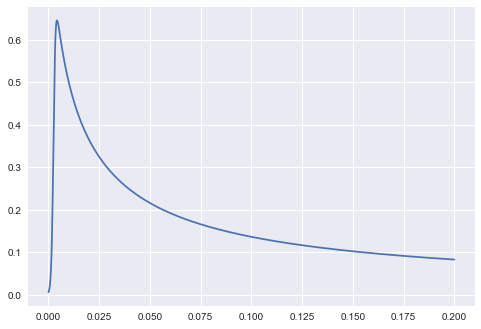

In [289]:
import matplotlib.pyplot as plt
import seaborn

xs = np.linspace(0,0.2,1000)
ys = e.evaluate_points_on_distribution_at_fixed_value(xs, 1)

plt.plot(xs, ys)
plt.show()

In [267]:
e = Explorer()
e.generate_space(embedded_prods)
midpoints_to_evaluate = e.gridify_space(grid_size, grid_size)
high_dim_midpoints = dimensionality_projection(midpoints_to_evaluate, kpca_model)
print "Evaluating sampling space..."
values = model.predict(high_dim_midpoints)
evaluated_midpoints = np.hstack((midpoints_to_evaluate, np.atleast_2d(values).T))
print "Sampling..."
samples = e.sample_space(evaluated_midpoints, N)
high_dim_samples = dimensionality_projection(samples, kpca_model)
print "Evaluating samples..."
sample_values = model.predict(high_dim_samples)


Evaluating sampling space...
Sampling...
[[-0.16752466 -0.26505792  3.36710973]
 [-0.16752466 -0.2573869   3.38103348]
 [-0.16752466 -0.24971587  3.34528227]
 ..., 
 [ 0.22059111  0.0647961   1.86872631]
 [ 0.22059111  0.07246712  1.86872631]
 [ 0.22059111  0.08397366  1.86872631]]
Evaluating samples...


In [244]:
e3 = Explorer3D()
e3.generate_space(embedded_prods3)
midpoints_to_evaluate3 = e3.gridify_space(grid_size3, grid_size3, grid_size3)
high_dim_midpoints3 = dimensionality_projection(midpoints_to_evaluate3, kpca_model3)
print "Evaluating sampling space..."
values3 = model.predict(high_dim_midpoints3)
evaluated_midpoints3 = np.hstack((midpoints_to_evaluate3, np.atleast_2d(values3).T))
print "Sampling..."
samples3 = e3.sample_space(evaluated_midpoints3, N)
high_dim_samples3 = dimensionality_projection(samples3, kpca_model3)
print "Evaluating samples..."
sample_values3 = model.predict(high_dim_samples3)


Evaluating sampling space...
Sampling...
[[-0.21601736 -0.26825418 -0.14830865  2.4372419 ]
 [-0.21601736 -0.26825418 -0.03769882  2.38627151]
 [-0.21601736 -0.26825418 -0.02387259  2.5101771 ]
 ..., 
 [ 0.1629509   0.10251196 -0.07917751  2.5481972 ]
 [ 0.1629509   0.10251196  0.10056348  2.5481972 ]
 [ 0.1629509   0.10251196  0.18352086  2.33448616]]
Evaluating samples...


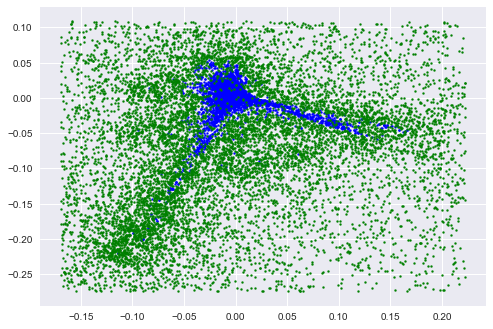

In [281]:
plt.scatter(embedded_prods[:,0], embedded_prods[:,1], s=4, c='b')
plt.scatter(samples[:,0], samples[:,1], s=4, c='g')

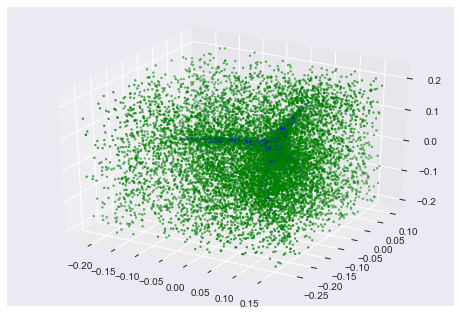

In [282]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedded_prods3[:,0], embedded_prods3[:,1], embedded_prods3[:,2], zdir='z', s=4, c='b', depthshade=True)
ax.scatter(samples3[:,0], samples3[:,1], samples3[:,2], zdir='z', s=4, c='g', depthshade=True)

In [286]:
boolean_samples = high_dim_samples > output_threshold
original_samples = np.copy(samples)
print np.sum(boolean_samples, axis=1)
boolean_samples_temp = boolean_samples[np.sum(boolean_samples, axis=1) > minimum_descriptors]
original_samples = original_samples[np.sum(boolean_samples, axis=1) > minimum_descriptors]
boolean_samples = boolean_samples_temp
print np.sum(boolean_samples, axis=1)
boolean_samples_temp = boolean_samples[np.sum(boolean_samples, axis=1) < maximum_descriptors]
original_samples = original_samples[np.sum(boolean_samples, axis=1) < maximum_descriptors]
boolean_samples = boolean_samples_temp
print np.sum(boolean_samples, axis=1)
a = boolean_samples
b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
_, idx = np.unique(b, return_index=True)
boolean_samples = a[idx]
print np.sum(boolean_samples, axis=1)

[17 16 14 ...,  5  5  5]
[17 16 14 ...,  5  5  5]
[17 16 14 ...,  5  5  5]
[ 1  1  1  2  2  2  3  3  4  4  5  2  3  3  4  5  4  6  4  5  6  7  6  7  7
  7  8  8  9  7  8  9 10 10  2  4  3  4  5  6  8  9 10  4  5  5  6  7  5  7
  8 11 12  6  7  8  7  8  9  9 10  9 11 10 12 13 11 12  9 10 10 11 11 12 11
 12 13 11 12 13 14 15 13 14 15 16 14 15 16 17 18 17 19  9 11 12 13 14 16 20
 14 15 17 18 21 10 11 12 13 11 12 13 14 15 15 16 17 15 16 18 20 16 19 20 21
 17 18 19 20 21 22 22]


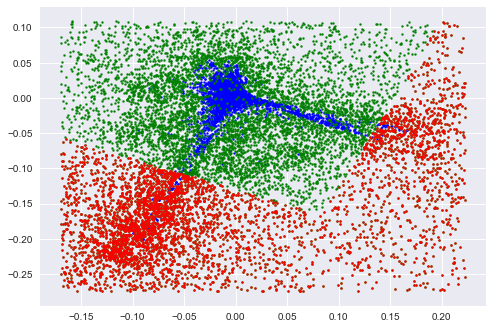

In [287]:
plt.scatter(embedded_prods[:,0], embedded_prods[:,1], s=4, c='b')
plt.scatter(samples[:,0], samples[:,1], s=4, c='g')
plt.scatter(original_samples[:,0], original_samples[:,1], s=4, c='r')

In [273]:
boolean_samples3 = high_dim_samples3 > output_threshold
print np.sum(boolean_samples3, axis=1)
boolean_samples3 = boolean_samples3[np.sum(boolean_samples3, axis=1) > minimum_descriptors]
print np.sum(boolean_samples, axis=1)
boolean_samples3 = boolean_samples3[np.sum(boolean_samples3, axis=1) < maximum_descriptors]
print np.sum(boolean_samples3, axis=1)
a = boolean_samples3
b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
_, idx = np.unique(b, return_index=True)
boolean_samples3 = a[idx]
print np.sum(boolean_samples3, axis=1)

[80 70 72 ..., 17 20 49]
[ 1  1  2 ..., 75 76 77]
[80 70 72 ..., 17 20 49]
[ 1  1  2 ..., 93 97 85]


In [274]:
[get_words_from_vec(sample, top_ranked_words) for sample in boolean_samples]

set([u'weatherproof'])
set([u'deluxe'])
set([u'deluxe', u'secure'])
set([u'browser'])
set([u'colors', u'browser'])
set([u'2g', u'browser'])
set([u'weatherproof', u'2g', u'browser'])
set([u'depth'])
set([u'alltel', u'2g', u'browser'])
set([u'games'])
set([u'colors', u'games', u'browser'])
set([u'depth', u'games'])
set([u'6pc'])
set([u'deluxe', u'6pc'])
set([u'deluxe', u'secure', u'6pc'])
set([u'deluxe', u'vivitar', u'6pc'])
set([u'depth', u'6pc'])
set([u'precision', u'6pc'])
set([u'depth', u'precision', u'6pc'])
set([u'deluxe', u'additional', u'6pc'])
set([u'deluxe', u'additional', u'6pc', u'secure'])
set([u'deluxe', u'additional', u'6pc', u'vivitar'])
set([u'deluxe', u'secure', u'additional', u'6pc', u'vivitar'])
set([u'secure', u'vivitar', u'dx', u'6pc', u'deluxe', u'additional'])
set([u'deluxe', u'rebel', u'6pc'])
set([u'rebel', u'6pc', u'precision'])
set([u'deluxe', u'vivitar', u'rebel', u'6pc', u'precision'])
set([u'depth', u'rebel', u'6pc', u'precision'])
set([u'vivitar', u'precis

[{u'weatherproof'},
 {u'deluxe'},
 {u'deluxe', u'secure'},
 {u'browser'},
 {u'browser', u'colors'},
 {u'2g', u'browser'},
 {u'2g', u'browser', u'weatherproof'},
 {u'depth'},
 {u'2g', u'alltel', u'browser'},
 {u'games'},
 {u'browser', u'colors', u'games'},
 {u'depth', u'games'},
 {u'6pc'},
 {u'6pc', u'deluxe'},
 {u'6pc', u'deluxe', u'secure'},
 {u'6pc', u'deluxe', u'vivitar'},
 {u'6pc', u'depth'},
 {u'6pc', u'precision'},
 {u'6pc', u'depth', u'precision'},
 {u'6pc', u'additional', u'deluxe'},
 {u'6pc', u'additional', u'deluxe', u'secure'},
 {u'6pc', u'additional', u'deluxe', u'vivitar'},
 {u'6pc', u'additional', u'deluxe', u'secure', u'vivitar'},
 {u'6pc', u'additional', u'deluxe', u'dx', u'secure', u'vivitar'},
 {u'6pc', u'deluxe', u'rebel'},
 {u'6pc', u'precision', u'rebel'},
 {u'6pc', u'deluxe', u'precision', u'rebel', u'vivitar'},
 {u'6pc', u'depth', u'precision', u'rebel'},
 {u'6pc', u'deluxe', u'depth', u'precision', u'rebel', u'vivitar'},
 {u'6pc', u'additional', u'deluxe', u'reb

In [264]:
[get_words_from_vec(sample, top_ranked_words) for sample in boolean_samples3]

set([u'depth', u'2g', u'colors'])
set([u'alltel', u'2g', u'browser'])
set([u'alltel', u'2g', u'colors', u'browser'])
set([u'alltel', u'2g', u'colors', u'depth'])
set([u'depth', u'automatic', u'weatherproof'])
set([u'mp4', u'2g', u'alltel'])
set([u'mp4', u'2g', u'colors', u'alltel'])
set([u'mp4', u'2g', u'alltel', u'browser'])
set([u'mp4', u'2g', u'colors', u'alltel', u'browser'])
set([u'deluxe', u'additional', u'secure'])
set([u'weatherproof', u'deluxe', u'additional', u'secure'])
set([u'depth', u'games', u'colors'])
set([u'alltel', u'2g', u'games', u'colors', u'browser'])
set([u'colors', u'alltel', u'2g', u'games', u'depth'])
set([u'alltel', u'depth', u'colors', u'2g', u'games', u'browser'])
set([u'alltel', u'mp4', u'colors', u'2g', u'games', u'browser'])
set([u'colors', u'alltel', u'mp4', u'depth', u'2g', u'games'])
set([u'colors', u'alltel', u'mp4', u'depth', u'2g', u'games', u'browser'])
set([u'deluxe', u'secure', u'6pc'])
set([u'deluxe', u'vivitar', u'6pc'])
set([u'alltel', u'vivi

[{u'2g', u'colors', u'depth'},
 {u'2g', u'alltel', u'browser'},
 {u'2g', u'alltel', u'browser', u'colors'},
 {u'2g', u'alltel', u'colors', u'depth'},
 {u'automatic', u'depth', u'weatherproof'},
 {u'2g', u'alltel', u'mp4'},
 {u'2g', u'alltel', u'colors', u'mp4'},
 {u'2g', u'alltel', u'browser', u'mp4'},
 {u'2g', u'alltel', u'browser', u'colors', u'mp4'},
 {u'additional', u'deluxe', u'secure'},
 {u'additional', u'deluxe', u'secure', u'weatherproof'},
 {u'colors', u'depth', u'games'},
 {u'2g', u'alltel', u'browser', u'colors', u'games'},
 {u'2g', u'alltel', u'colors', u'depth', u'games'},
 {u'2g', u'alltel', u'browser', u'colors', u'depth', u'games'},
 {u'2g', u'alltel', u'browser', u'colors', u'games', u'mp4'},
 {u'2g', u'alltel', u'colors', u'depth', u'games', u'mp4'},
 {u'2g', u'alltel', u'browser', u'colors', u'depth', u'games', u'mp4'},
 {u'6pc', u'deluxe', u'secure'},
 {u'6pc', u'deluxe', u'vivitar'},
 {u'6pc', u'alltel', u'vivitar'},
 {u'2g', u'6pc', u'alltel'},
 {u'6pc', u'precisi

# Results